# Circuit Discovery

In [27]:
from scipy.stats import gamma
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import scipy
import matplotlib
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 5.0)

def fft(y, N=600, T=0.00125):
    yf = scipy.fft.fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))
    return xf, 2.0/N * np.abs(yf[:N//2])

def inverse_fft(y, n=100):
    y = scipy.fft.ifft(yf, n).astype(float)
    y = y.reshape(n, 1)
    scaler = MinMaxScaler((-1, 1))
    y3 = scaler.fit_transform(y)
    return y3

def get_sinwave(f=1, t=1, N=44100):
    samples = np.linspace(0, t, int(N*t), endpoint=False)
    signal = np.sin(2 * np.pi * f * samples)
    return samples, signal

def hrf(times):
    peak_values = gamma.pdf(times, 6)
    undershoot_values = gamma.pdf(times, 12)
    values = peak_values - 0.35 * undershoot_values
    return values / np.max(values) * 0.6

In [3]:
def G1(times):
    values = gamma.pdf(times, 6)
    return values / np.max(values)

In [4]:
def G2(times):
    values = gamma.pdf(times, len(times)/2)
    return values / np.max(values) * 0.6

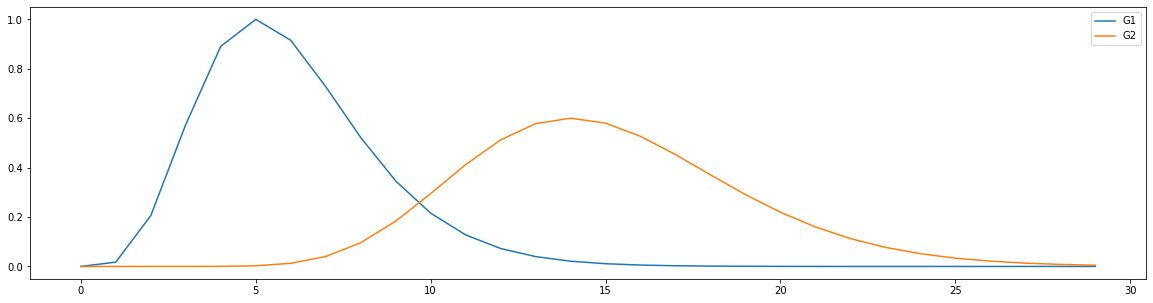

In [5]:
t = np.arange(0, 30, 1)
g1_sig = G1(t); plt.plot(g1_sig);
g2_sig = G2(t); plt.plot(g2_sig);
plt.legend(['G1', 'G2']);

In [6]:
u = [1 if i%20==0 else 0 for i in range(1, 100)]
g1 = np.convolve(u, g1_sig)
g2 = np.convolve(u, g2_sig)

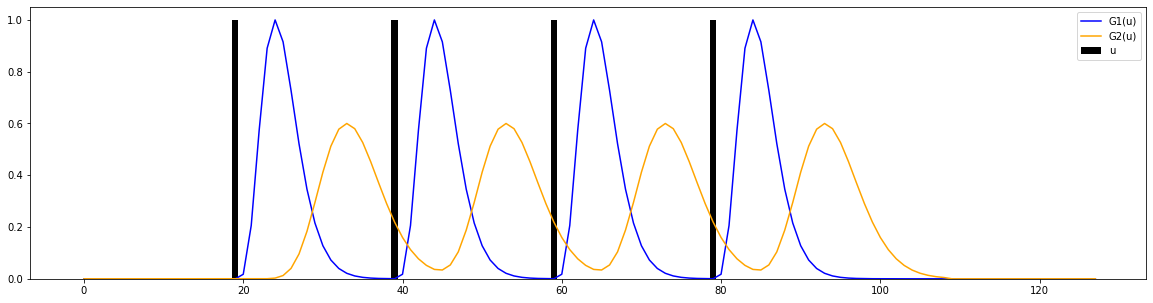

In [7]:
plt.bar(range(len(u)), u, color='black');
plt.plot(g1, color='blue');
plt.plot(g2, color='orange');
plt.legend(['G1(u)', 'G2(u)', 'u']);

<img src="main.png" alt="Circuit Discovery" style="height: 200px;"/>

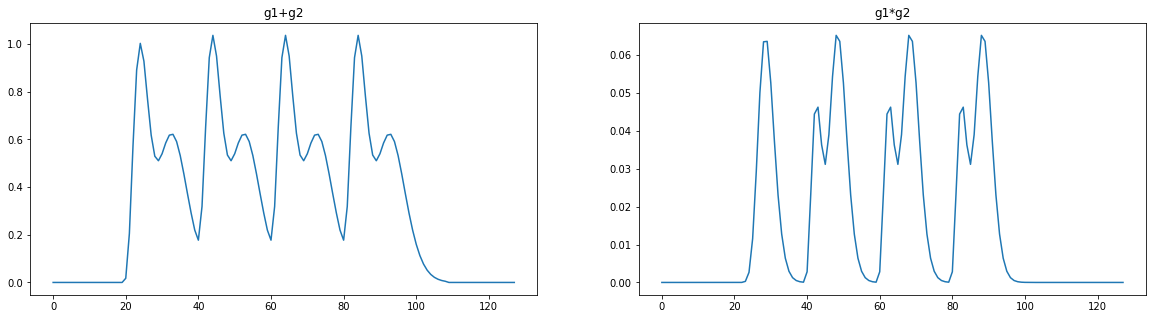

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2);
ax1.plot(g1+g2); ax1.set_title('g1+g2');
ax2.plot(g1*g2); ax2.set_title('g1*g2');
# plt.

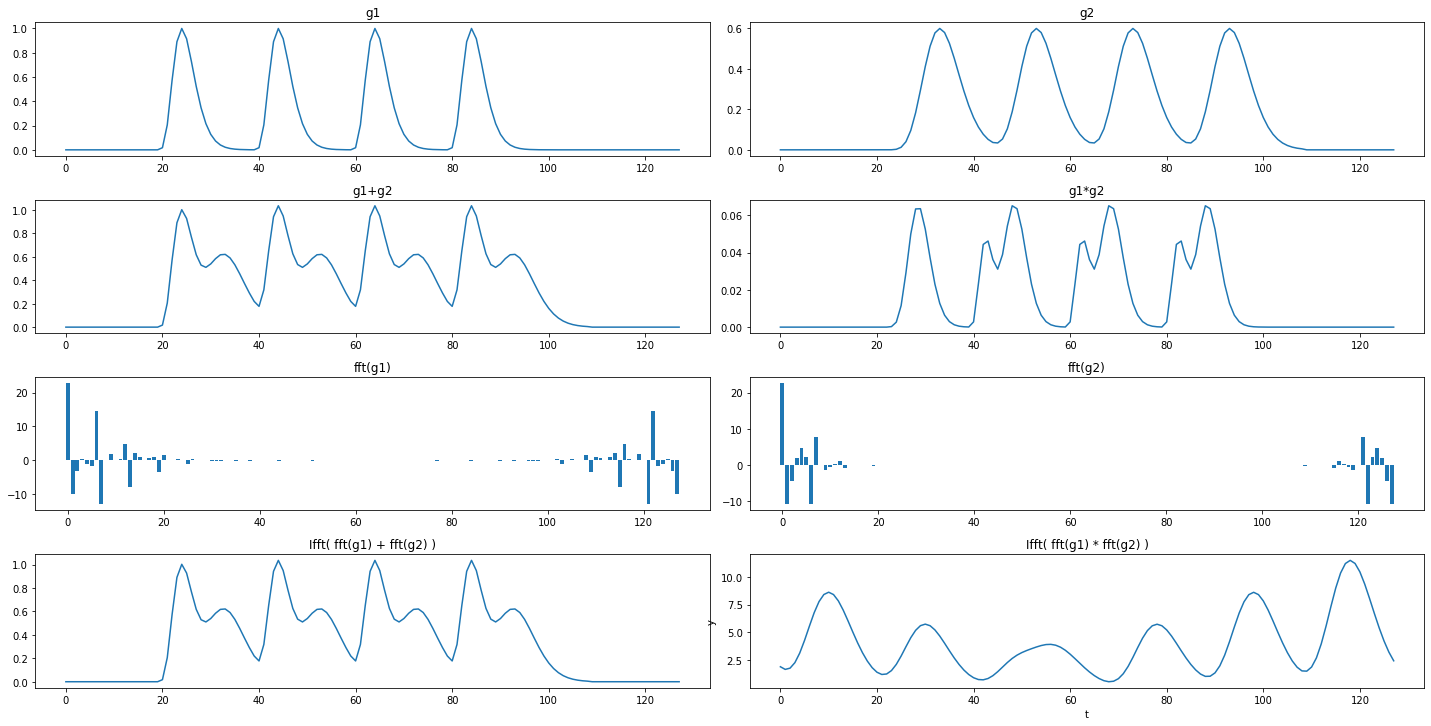

In [9]:
g1f = scipy.fft.fft(g1)
g2f = scipy.fft.fft(g2)

n = range(len(g1f))
fig, axs = plt.subplots(4, 2, figsize=(20, 10))
axs = [cell for row in axs for cell in row]
axs[0].plot(g1); axs[0].set_title('g1');
axs[1].plot(g2); axs[1].set_title('g2');
axs[2].plot(g1+g2);axs[2].set_title('g1+g2');
axs[3].plot(g1*g2);axs[3].set_title('g1*g2');
axs[4].bar(n, g1f);axs[4].set_title('fft(g1)');
axs[5].bar(n, g2f);axs[5].set_title('fft(g2)');
axs[6].plot(n, scipy.fft.ifft(g1f+g2f));axs[6].set_title('Ifft( fft(g1) + fft(g2) )');
axs[7].plot(n, scipy.fft.ifft(g1f*g2f));axs[7].set_title('Ifft( fft(g1) * fft(g2) )');
plt.tight_layout(); plt.xlabel('t'); plt.ylabel('y');

### Negative Feedback Loop
<img src="negativeloop.jpg" alt="Negative feedback loop" style="width: 400px;"/>
$Y (s) = Z (s) . G (s)$

$Z (s) = X (s) – Y (s) . H (s)$

$X (s) = Z (s) + Y (s) . H (s)$

$X (s) = Z (s) + Z (s) . G (s) . H (s)$

So $(Y (s))/(X (s)) = (Z (s).G (s))/(Z (s)+ Z(s)G(s)H(s))$

$(Y (s))/(X (s)) = (G (s))/(1+ G(s).H(s))$

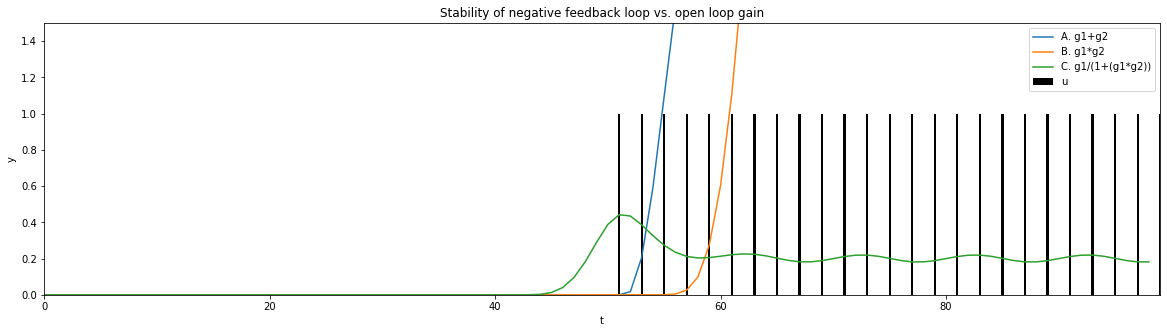

In [14]:
u = np.concatenate([[0]*50, [0, 1]*25])
g1 = np.convolve(u, g1_sig)
g2 = np.convolve(u, g2_sig)
plt.bar(range(len(u)), u, color='black', width=0.2);
plt.plot(g1+g2);
plt.plot(g1*g2);
a = g1+g2
b = g1*g2
plt.xlim(0, len(u)-1); plt.ylim(0, 1.5);
u = ([0]*30)+[1 if i%10==0 else 0 for i in range(1, 70)]
g1 = np.convolve(u, g2_sig)[:len(u)]
g2 = np.convolve(g1, g1_sig)[:len(u)]
c = g1/(1+(g1*g2))
plt.plot(c)
plt.legend(['A. g1+g2', 'B. g1*g2', 'C. g1/(1+(g1*g2))', 'u']);
plt.xlabel('t'); plt.ylabel('y');
plt.title('Stability of negative feedback loop vs. open loop gain');

<img src="main.png" alt="Circuit Discovery" style="width: 500px;"/>

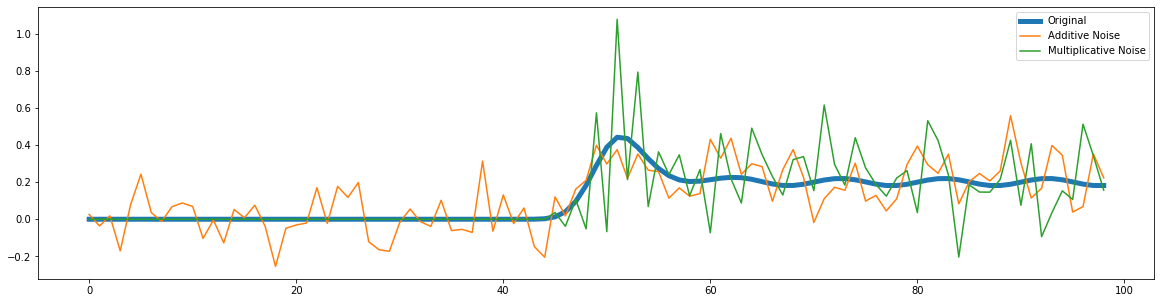

In [11]:
plt.plot(c, linewidth=5);
m, a = 1, 1
add_noise  = c +  np.random.normal(0, np.std(c)*a, len(c))
mult_noise = c + (c*(np.random.normal(0, m, len(c))))
plt.plot(add_noise);
plt.plot(mult_noise);
plt.legend(['Original', 'Additive Noise', 'Multiplicative Noise']);

In [15]:
import pandas as pd 
X = []
y = []
a_noises = []
m_noises = []
for i, x in enumerate([a, b, c]):
    for a_w in [0.1, 0.2, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
        for m_w in [0.1, 0.2, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
            for j in range(200):
                a_noise = np.random.normal(0, np.std(x)*a_w, len(x))
                m_noise = np.random.normal(0, m_w, len(x))
                x_w_noise = (x+a_noise)+ x*m_noise
                feat = scipy.fft.fft(x_w_noise)[:int(len(x)/2)]
                a_noises.append(a_w)
                m_noises.append(m_w)
                X.append(feat)
                y.append(i)
    
X = pd.DataFrame(X).astype(float)
X['label'] = y
X['a_noise'] = a_noises
X['m_noise'] = m_noises
X = X.sample(frac=1).fillna(X.mean())

In [16]:
# fig, axs = plt.subplots(1, 4, gridspec_kw={'width_ratios': [9, 0.25, 0.5, 0.25]});
# features = axs[0].imshow(np.log(X[X.columns[:-1]]), aspect='auto', cmap='Reds');
# labels = axs[2].imshow(X[X.columns[-1]].values.reshape(len(X), 1), aspect='auto', cmap='Blues');
# fig.colorbar(features, axs[1], aspect=10, ticks=[-100, 300]);
# fig.colorbar(labels, axs[3], aspect='auto', ticks=[0, 1, 2]);
# axs[0].set_title('X (features Hz)'); axs[0].set_ylabel('Samples');
# axs[2].set_title('y (circuit A, B or C)');axs[1].set_ylabel('Samples');
# plt.tight_layout();

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X.drop('label', axis=1), X['label'])
clf = LogisticRegression(random_state=0).fit(X_train.drop(['a_noise', 'm_noise'], axis=1), y_train)
preds = clf.predict(X_test.drop(['a_noise', 'm_noise'], axis=1))
print(classification_report(y_test, preds, target_names=['A. Serial', 'B. Parallel', 'C. Feedback']))

              precision    recall  f1-score   support

   A. Serial       0.91      0.91      0.91      3242
 B. Parallel       0.91      0.92      0.92      3175
 C. Feedback       1.00      0.98      0.99      3183

    accuracy                           0.94      9600
   macro avg       0.94      0.94      0.94      9600
weighted avg       0.94      0.94      0.94      9600



In [18]:
results = []
for a_noise in X['a_noise'].unique():
    for m_noise in X['m_noise'].unique():
        f_map = (X_test['a_noise']==a_noise) & (X_test['m_noise']==m_noise)
        if f_map.sum()==0:
            continue
        filtered= X_test.loc[f_map]
        preds = clf.predict(filtered.drop(['a_noise', 'm_noise'], axis=1))
        results.append((a_noise, m_noise, accuracy_score(y_test[f_map], preds)))
results = pd.DataFrame(results)
results.columns = ['a_noise', 'm_noise', 'acc']

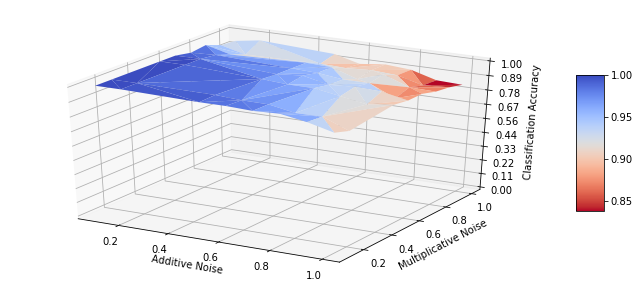

In [46]:
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (12.0, 5.0)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(results['a_noise'], results['m_noise'], results['acc'], cmap=cm.coolwarm_r, linewidth=0)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5);
ax.set_xlabel('Additive Noise');
ax.set_ylabel('Multiplicative Noise');
ax.set_zlabel('Classification Accuracy');
ax.set_zlim(0, 1);

In [96]:
test.shape

(8, 8)

In [89]:
ax.set_xticklabels?

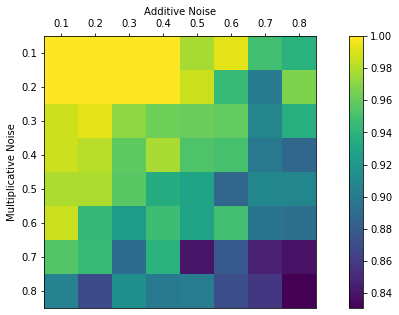

In [101]:
# %matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (12.0, 5.0)
fig = plt.figure()
ax = fig.gca()#projection='3d')
Xi,Yi = np.meshgrid(results['a_noise'], results['m_noise'])

test = results.pivot(index='a_noise', columns='m_noise', values=['acc'])
a = ax.imshow(test)
ax.set_xticklabels(np.round(np.arange(0, 1.1, 0.1), 2))
ax.set_yticklabels(np.round(np.arange(0, 1.1, 0.1), 2))
ax.xaxis.tick_top()
fig.colorbar(a);
ax.set_xlabel('Additive Noise');
ax.xaxis.set_label_position('top') ;
ax.set_ylabel('Multiplicative Noise');

# Library

In [228]:
import os
import matplotlib.pyplot as plt  
from control.matlab import *
from control import *
from tqdm import tqdm
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 5.0)

G1 = tf2ss([1, 3, 1], [1, 1, 1])
G2 = tf2ss([1, 2, 1], [1, 1, 1])

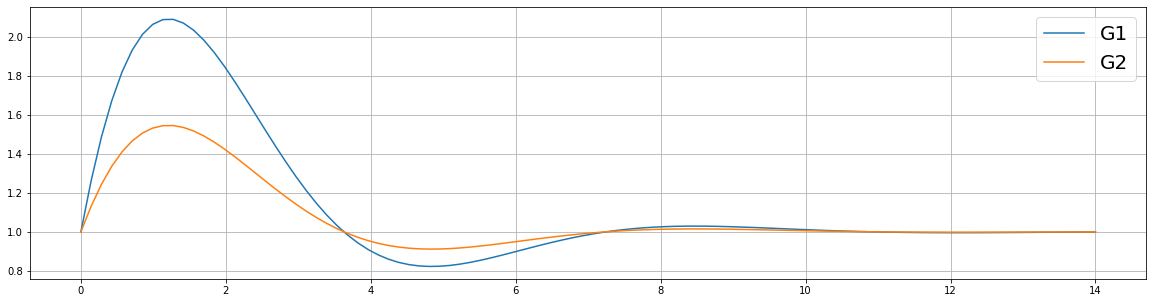

In [229]:
g1, T = step(G1)
g2, T = step(G2)
plt.plot(T.T, g1.T);
plt.plot(T.T, g2.T);
plt.grid();
plt.legend(['G1', 'G2'], fontsize=20);

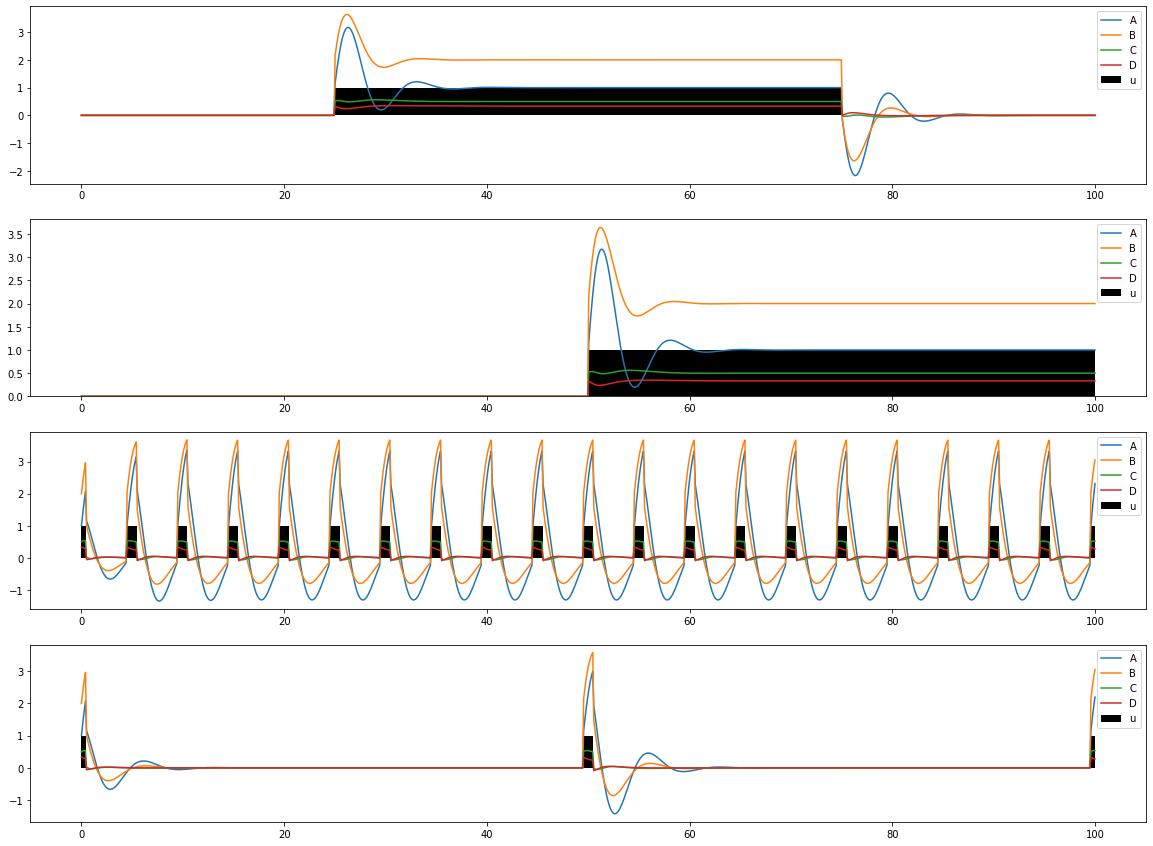

In [230]:
fig, axs = plt.subplots(4, 1, figsize=(20, 15))

time = np.linspace(start=0, stop=100, num=1000)

u1 = [1 if (i>25) & (i<75) else 0 for i in time]
u2 = [1 if i>50 else 0 for i in time]
u3 = [1 if round(i, 0)%5==0 else 0 for i in time]
u4 = [1 if round(i, 0)%50==0 else 0 for i in time]

for i, u in enumerate([u1, u2, u3, u4]):
    axs[i].bar(time, u, color='black', width=0.1);

    A = series(G1, G2)
    B = parallel(G1, G2)
    C = feedback(G1, G2, sign=-1)
    D = feedback(C, G1, sign=-1)
    for x in [A, B, C, D]:
        T, yout, xout = forced_response(x, time, u)
        axs[i].plot(T.T, yout.T);
        axs[i].legend(['A', 'B', 'C', 'D', 'u'])

In [103]:
from numpy.random import choice

#spike train
u = [1 if (i>25) & (i<75) else 0 for i in time]

#nodes
N = 10

#G1, G2, G3...
Gs = [G1, G2]
N_Gs = len(Gs) 

#P(G1), P(G2), P(G3)...
p_Gs = [0.5, 0.5] 

# none, serial, parallel, feedback
conns = [0, 1, 2, 3] 
# P(none), P(serial), P(parallel), P(feedback)
conns_p = [0.5, 0.5/3, 0.5/3, 0.5/3] 
N_conns = len(conns)

NameError: name 'time' is not defined

In [102]:
G = choice(Gs, N, p=p_Gs)
# [('node %s'% i, 'G1') if g==1 else ('node %s' % i, 'G2') for i, g in enumerate(G)]
G

NameError: name 'choice' is not defined

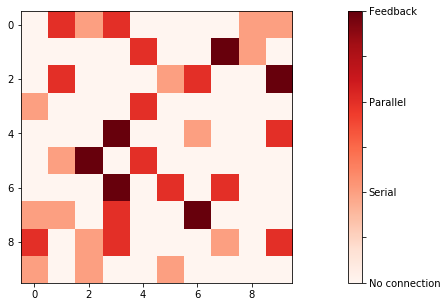

In [270]:
conn = choice([0, 1, 2, 3], N*N, p=[0.5, 0.5/3, 0.5/3, 0.5/3]).reshape(N, N)
np.fill_diagonal(conn, 0);
plt.imshow(conn, cmap='Reds');
cbar = plt.colorbar();
cbar.ax.set_yticklabels(['No connection', '', 'Serial','', 'Parallel','', 'Feedback']);

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2);
ax1.imshow(g1+g2); ax1.set_title('g1+g2');
ax2.imshow(g1*g2); ax2.set_title('g1*g2');
# plt.

# Scratchpad

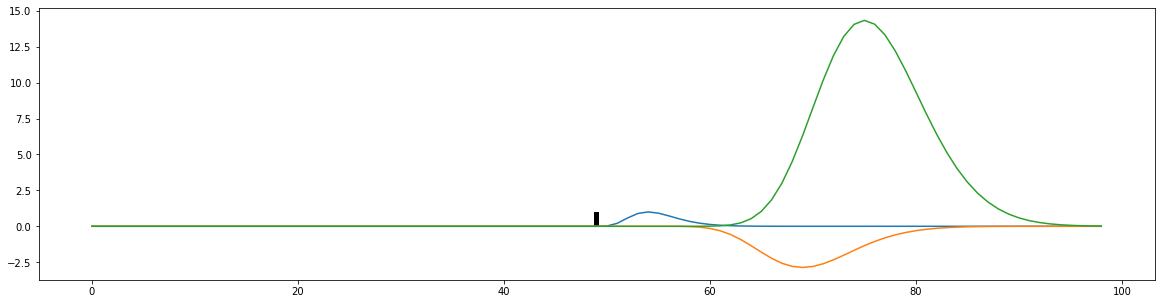

In [752]:
final = []
u = [1 if i%50==0 else 0 for i in range(1, 100)]
g1 = np.convolve(u, g1_sig)[:len(u)]
g2 = np.convolve(g1, -1*g2_sig)[:len(u)]
g3 = np.convolve(g2, -1*g1_sig)[:len(u)]
plt.bar(range(len(u)), u, color='black', width=0.5);
plt.plot(g1)
plt.plot(g2)
plt.plot(g3)

In [734]:
final = []
ys = []
g2s = []
# u = [1 if i%10==0 else 0 for i in range(1, 100)]
# u = np.repeat([0., 1., 1., 1.], 25)
u = [1 if i%50==0 else 0 for i in range(1, 100)]
g1 = np.convolve(u, g1_sig)[:len(u)]
g2 = np.convolve(g1, g1_sig)[:len(u)]
# print(len(u))
for t in range(1, len(u)):
    y = np.convolve(u+(-1*g2), g1_sig)[:len(u)]
    g2 = np.convolve(y, g1_sig)[:len(u)]
    final.append(y[t])
#     print(t, len(y), len(g2), y[t])

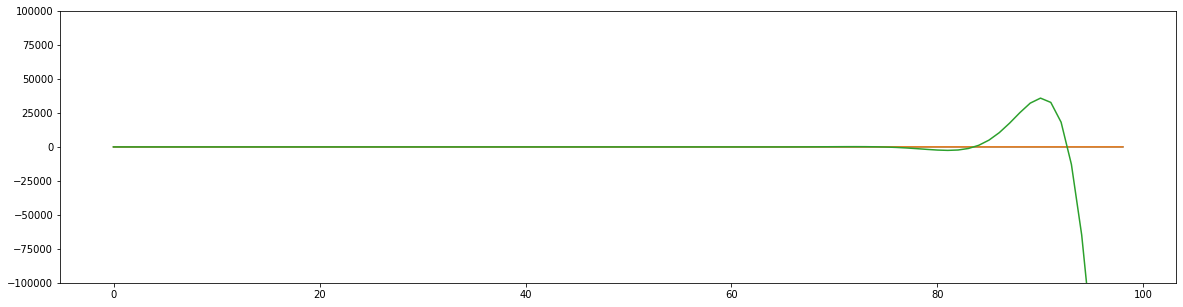

In [743]:
plt.bar(range(len(u)), u, color='black', width=0.5);
plt.plot(np.convolve(u, g1_sig)[:len(u)])
plt.plot(np.convolve(u, g1_sig)[:len(u)])
plt.plot(final);
plt.ylim(-100000, 100000);
# final

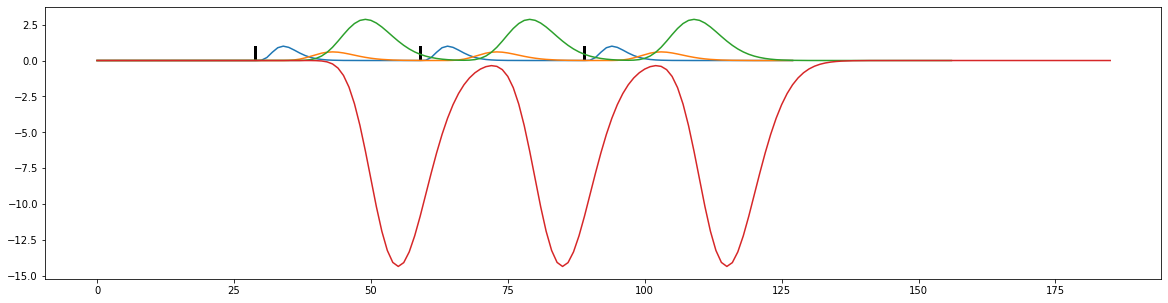

In [706]:
u = [1 if i%30==0 else 0 for i in range(1, 100)]
n = len(u)

g1 = np.convolve(u, g1_sig);
g2 = np.convolve(u, g2_sig);
g3 = np.convolve(g1, g2_sig);
g4 = np.convolve(-1*g3, g1_sig);
plt.bar(range(len(u)), u, color='black', width=0.5);
plt.plot(g1);
plt.plot(g2);
plt.plot(g3);
plt.plot(g4);

In [699]:
def my_conv(u, sig):
    inds = [i for i, x in enumerate(u) if x == 1]
    components = []
    for i in inds:
        comp = np.zeros(len(u))
        comp[i:i+len(sig)] = sig[:min(len(u)-i, len(sig))]
        components.append(comp)
    return np.array(components)

3 3


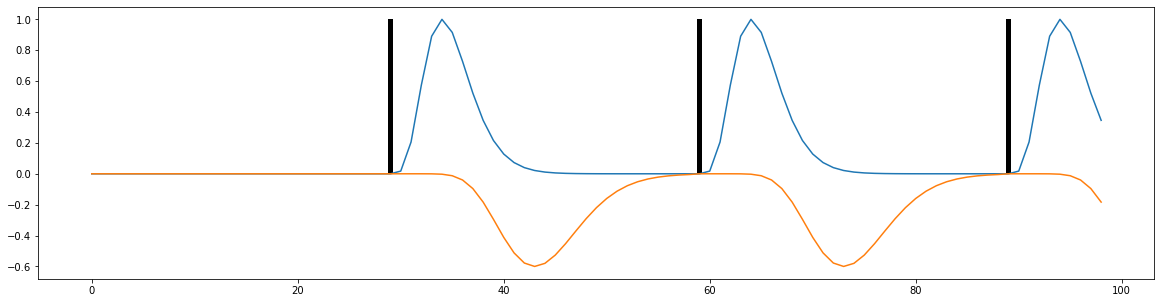

In [702]:
# u = np.concatenate([[0]*50, [0, 1]*25])
u = [1 if i%30==0 else 0 for i in range(1, 100)]
# plt.bar(range(len(u)), u, color='black', width=0.5);
comps_g1 = my_conv(u, g1_sig)
comps_g2 = my_conv(u, -1*g2_sig)
print(len(comps_g1), len(comps_g2))

# for t in range(1, len(u)):
#     y = np.convolve(u-g2, g1_sig)[:len(u)]
#     g2 = np.convolve(y, g2_sig)[:len(u)]
#     final.append(y[t])
    
final = []
spike = 0
for t in range(1, len(u)-1):
    y = (u[t]-comps_g2[spike][t-1])*comps_g1[spike][t]
    final.append(y)
    spike = spike+1 if t==1 else spike
    
plt.bar(range(len(u)), u, color='black', width=0.5);
plt.plot(np.sum(comps_g1, axis=0));
plt.plot(np.sum(comps_g2, axis=0));
# plt.plot(final);
# plt.plot
# final

In [ ]:
u = [1 if i%10==0 else 0 for i in range(1, 100)]
plt.bar(range(len(u)), u, color='black', width=0.5);
plt.plot(np.convolve(u, g1_sig));
plt.plot(-1*np.convolve(np.convolve(u, -1*g1_sig), g2_sig));
plt.plot(np.convolve(u, g1_sig)-np.convolve(u, g2_sig))

# Control library

In [730]:
import control